# Sanity Checking the NQG simulation

This notebook performs a simulation run with the default parameter set
for a single run. It is meant to provide quick diagnostics on the model
capabilities.



## Part 1. Dependences & Set-up

In [1]:
import sys
sys.path.append('../')

import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from cadCAD_tools import easy_run

pio.renderers.default = "png" # For GitHub rendering

## Part 2. Simulation set-up & execution

In [12]:
from nqg_model.params import INITIAL_STATE
from nqg_model.params import SINGLE_RUN_PARAMS
from nqg_model.params import TIMESTEPS
from nqg_model.params import SAMPLES
from nqg_model.structure import NQG_MODEL_BLOCKS

default_run_args = (INITIAL_STATE,
                     {k: [v] for k, v in SINGLE_RUN_PARAMS.items()},
                    NQG_MODEL_BLOCKS,
                    TIMESTEPS,
                    SAMPLES)
sim_df = easy_run(*default_run_args, assign_params=False).set_index('days_passed')


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 1, 10)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 1, 10)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


Flattening results:   0%|          | 0/501 [00:00<?, ?it/s]

Total execution time: 1.00s


In [13]:
sim_df.head(5)

,delta_days,users,user_round_decisions,delegatees,trustees,action_matrix,vote_matrix,per_project_voting,oracle_state,simulation,subset,run,timestep
days_passed,,,,,,,,,,,,,
0.0,NaN,[],{},{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,0
1.0,1.0,[],{},{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,1
2.0,1.0,"[User(label='0', reputation=<ReputationCategor...","{'0': Action.Abstain, '2': Action.Abstain}",{},"{'0': {}, '2': {}}","{'0': {}, '2': {}}","{'0': {'proj_5': 0.0, 'proj_0': 0.0, 'proj_8':...","{'proj_5': 0.0, 'proj_0': 0.0, 'proj_8': 0.0, ...","OracleState(pagerank_results={'0': 0.5, '2': 0...",0,0,1,2
3.0,1.0,"[User(label='0', reputation=<ReputationCategor...","{'0': Action.Abstain, '2': Action.Abstain, '4'...",{},"{'0': {}, '2': {}, '4': {'0', '2'}}","{'0': {}, '2': {}, '4': {}}","{'0': {'proj_5': 0.0, 'proj_0': 0.0, 'proj_8':...","{'proj_5': 0.0, 'proj_0': 0.0, 'proj_8': 0.0, ...",OracleState(pagerank_results={'0': 0.370129747...,0,0,1,3
4.0,1.0,"[User(label='0', reputation=<ReputationCategor...","{'0': Action.Abstain, '2': Action.Abstain, '4'...",{},"{'0': {}, '2': {}, '4': {'0', '2'}}","{'0': {}, '2': {}, '4': {}}","{'0': {'proj_5': 0.0, 'proj_0': 0.0, 'proj_8':...","{'proj_5': 0.0, 'proj_0': 0.0, 'proj_8': 0.0, ...",OracleState(pagerank_results={'0': 0.370129747...,0,0,1,4


In [33]:
sim_df.columns

Index(['delta_days', 'users', 'user_round_decisions', 'delegatees', 'trustees',
       'action_matrix', 'vote_matrix', 'per_project_voting', 'oracle_state',
       'simulation', 'subset', 'run', 'timestep'],
      dtype='object')

## Part 3. Compute Metrics

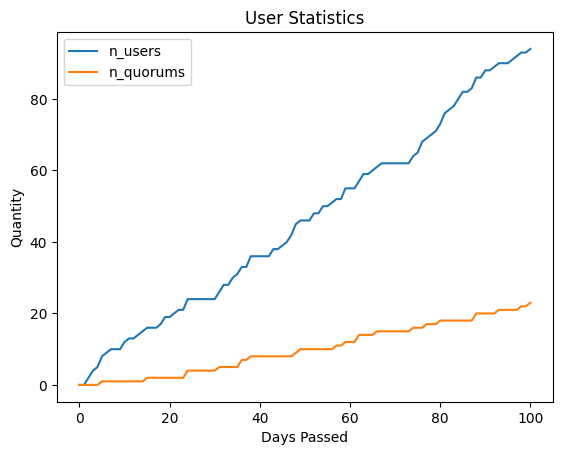

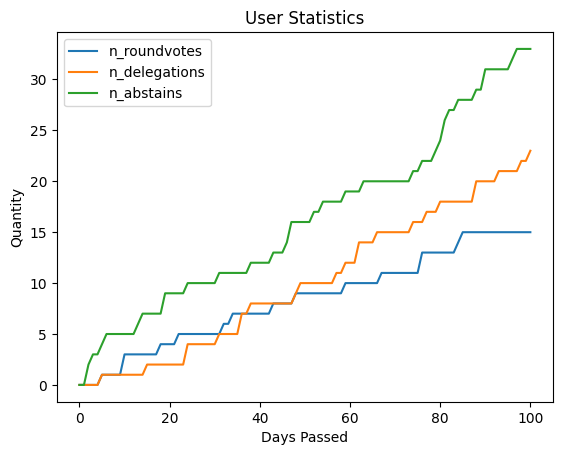

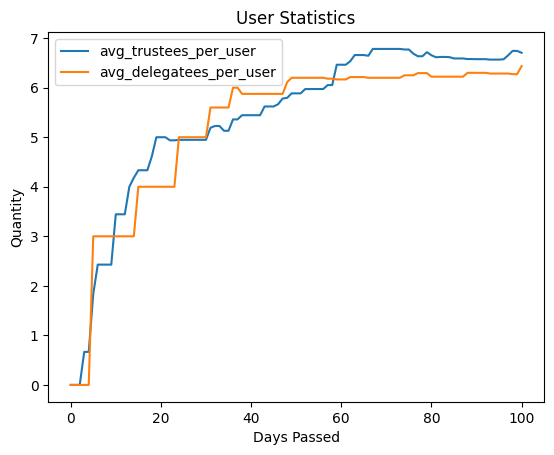

In [49]:
from nqg_model.types import Action
# Global metrics

metrics = {
    'n_users': lambda row: len(row.users),
    'n_quorums': lambda row: len(row.delegatees),
    'n_roundvotes': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.RoundVote]),
    'n_delegations': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Delegate]),
    'n_abstains': lambda row: len([1 for u, d in row.user_round_decisions.items() if d == Action.Abstain]),
    'avg_trustees_per_user': lambda row: sum(len(l) for l in row.trustees.values()) / len(row.trustees) if len(row.trustees) > 0 else 0.0,
    'avg_delegatees_per_user': lambda row: sum(len(l) for l in row.delegatees.values()) / len(row.delegatees) if len(row.delegatees) > 0 else 0.0,
}



new_df = sim_df.apply(metrics.values(), axis='columns')
new_df.columns = list(metrics.keys())

new_df[['n_users', 'n_quorums']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

new_df[['n_roundvotes', 'n_delegations', 'n_abstains']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()


new_df[['avg_trustees_per_user', 'avg_delegatees_per_user']].plot(xlabel='Days Passed', ylabel='Quantity', title='User Statistics')
plt.show()

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_37549/3580234388.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_37549/3580234388.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



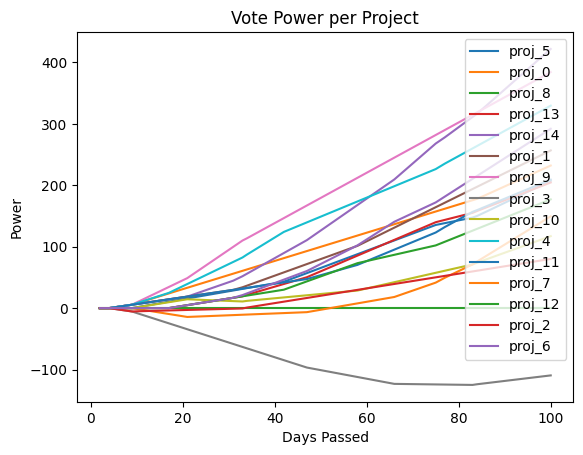

In [22]:
# Per project metrics

per_proj_votes = sim_df.per_project_voting.apply(pd.Series).dropna()
per_proj_votes.plot(title='Vote Power per Project', xlabel='Days Passed', ylabel='Power')
plt.show()

days_passed
0.0                                                     []
1.0                                                     []
2.0      [User(label='0', reputation=<ReputationCategor...
3.0      [User(label='0', reputation=<ReputationCategor...
4.0      [User(label='0', reputation=<ReputationCategor...
                               ...                        
96.0     [User(label='0', reputation=<ReputationCategor...
97.0     [User(label='0', reputation=<ReputationCategor...
98.0     [User(label='0', reputation=<ReputationCategor...
99.0     [User(label='0', reputation=<ReputationCategor...
100.0    [User(label='0', reputation=<ReputationCategor...
Name: users, Length: 101, dtype: object